Categorías seleccionadas: ['Apple 6', 'Apple Braeburn 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple hit 1', 'Apricot 1', 'Avocado 1', 'Avocado ripe 1', 'Banana 1', 'Banana Lady Finger 1']
Cargando imágenes de fruits-360/Training\Apple 6...
Cargando imágenes de fruits-360/Training\Apple Braeburn 1...
Cargando imágenes de fruits-360/Training\Apple Crimson Snow 1...
Cargando imágenes de fruits-360/Training\Apple Golden 1...
Cargando imágenes de fruits-360/Training\Apple Golden 2...
Cargando imágenes de fruits-360/Training\Apple Golden 3...
Cargando imágenes de fruits-360/Training\Apple Granny Smith 1...
Cargando imágenes de fruits-360/Training\Apple Pink Lady 1...
Cargando imágenes de fruits-360/Training\Apple Red 1...
Cargando imágenes de fruits-360/Training\Apple Red 2...
Cargando imágene

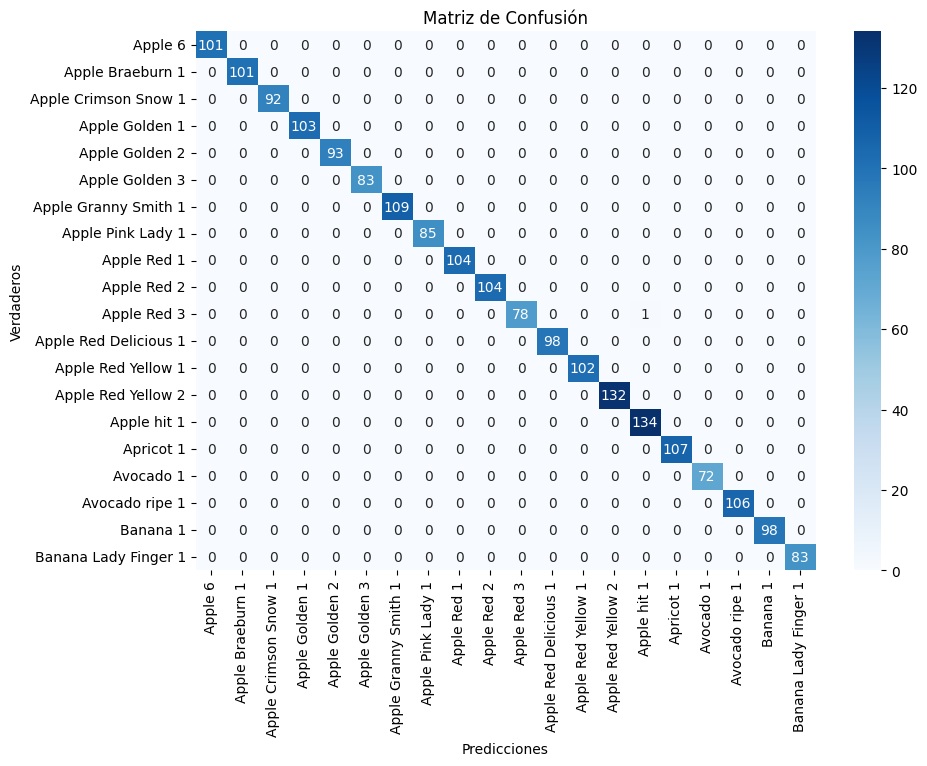

Imágenes clasificadas correctamente:


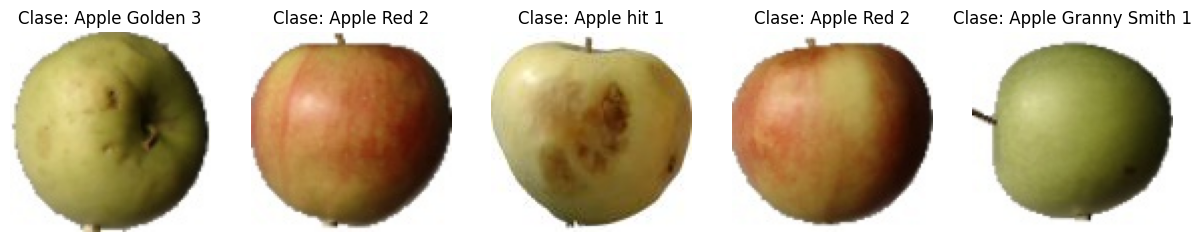

Imágenes clasificadas incorrectamente:


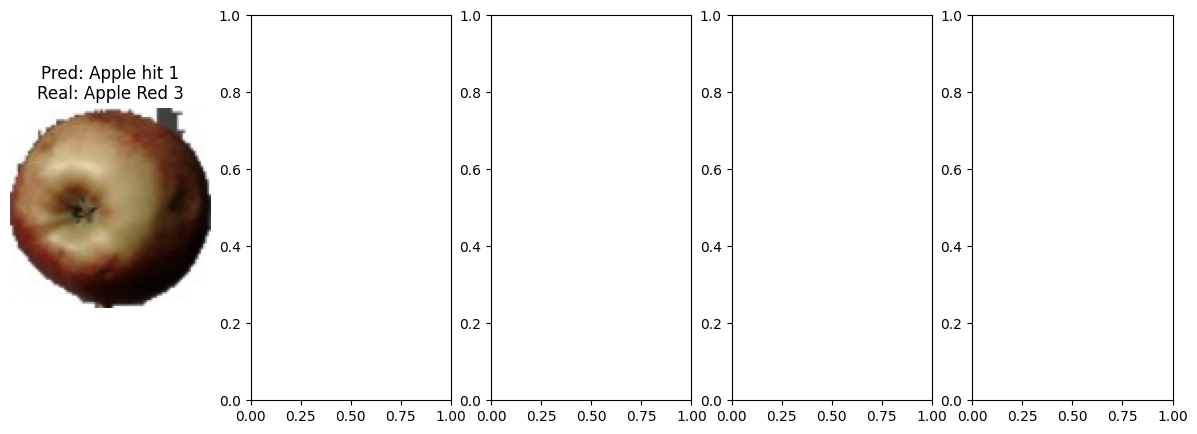

In [ ]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Conectar Google Drive
from google.colab import drive
drive.mount('/content/drive')
train_path = '/content/drive/MyDrive/ProyectoSemestral_IA/fruits-360/Training'
test_path = '/content/drive/MyDrive/ProyectoSemestral_IA/fruits-360/Test'

# Verificar que la carpeta existe
if not os.path.exists(train_path):
    raise FileNotFoundError(f"La carpeta de entrenamiento '{train_path}' no existe.")

# Detectar las categorías
categorias = sorted(os.listdir(train_path))[:20]  # tomar primeras 20
print(f"Categorías seleccionadas: {categorias}")

# Preprocesado de imágenes
def preprocesar_imagenes(ruta_carpeta, clase):
    data, clases = [], []
    for img_file in os.listdir(ruta_carpeta):
        img_path = os.path.join(ruta_carpeta, img_file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"No se pudo cargar imagen {img_path}. Saltando...")
            continue
        img = cv2.resize(img, (100, 100))  # Redimensionar a un tamaño fijo
        data.append(img.flatten())  # Aplanar la imagen a un vector 1D
        clases.append(clase)
    return np.array(data), np.array(clases)

# Cargar las imágenes del dataset
X, y = [], []
for idx, categoria in enumerate(categorias):
    categoria_ruta = os.path.join(train_path, categoria)

    if not os.path.exists(categoria_ruta):
        print(f"La carpeta de la categoria '{categoria}' no existe en la ruta '{categoria_ruta}'. Saltando...")
        continue

    print(f"Cargando imágenes de {categoria_ruta}...")
    data, clases = preprocesar_imagenes(categoria_ruta, idx)
    X.extend(data)
    y.extend(clases)

# Convertir a arrays de numpy
X = np.array(X)
y = np.array(y)

print(f"Número total de imágenes cargadas: {len(X)}")

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encontrar el mejor valor de k usando validación cruzada
k_valores = range(1, 21)
cv_scores = []

for k in k_valores:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Determinar el mejor k
mejor_k = k_valores[np.argmax(cv_scores)]
print(f"Mejor k: {mejor_k}")

# Entrenar el modelo con el mejor k
knn = KNeighborsClassifier(n_neighbors=mejor_k)
knn.fit(X_train_scaled, y_train)

# Evaluar en el conjunto de prueba
y_pred = knn.predict(X_test_scaled)

# Reporte de clasificación
report = classification_report(y_test, y_pred, target_names=categorias)
print("Reporte de Clasificación:")
print(report)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print(f"Matriz de Confusión:\n{cm}")

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=categorias, yticklabels=categorias)
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.show()
# Visualizar algunas imágenes clasificadas correctamente
correcto_indices = np.where(y_pred == y_test)[0]
print("Imágenes clasificadas correctamente:")
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, idx in enumerate(correcto_indices[:5]):
    img = X_test[idx].reshape(100, 100, 3)
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"Clase: {categorias[y_test[idx]]}")
    axes[i].axis('off')
plt.show()

# Visualizar algunas imágenes clasificadas incorrectamente
incorrecto_indices = np.where(y_pred != y_test)[0]
print("Imágenes clasificadas incorrectamente:")
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, idx in enumerate(incorrecto_indices[:5]):
    img = X_test[idx].reshape(100, 100, 3)
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"Pred: {categorias[y_pred[idx]]}\nReal: {categorias[y_test[idx]]}")
    axes[i].axis('off')
plt.show()